In [28]:
%matplotlib notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapefile
import matplotlib.dates as mdates
import seaborn as sns

In [29]:
from bs4 import BeautifulSoup
import requests
import json
import re

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="vv")

### Geocoding function

In [30]:
def do_geocode(g):
    try:
        loc = geolocator.geocode(g)
        print(loc.address)
        return loc
    except GeocoderTimedOut:
        return do_geocode(g)

In [31]:
# Timestamp
from datetime import date

today = date.today() # date object
# Format
time_stamp = today.strftime("%m-%d-%Y")

# Getting the data
### Dataset from www.endcov.ph by the University of the Philippines

In [4]:
url = 'https://endcov.ph/cases/#'
html_content = requests.get(url).text
soup = BeautifulSoup(html_content)

In [5]:
data = json.loads(soup.find('script',type='application/json').get_text()) #dictionary format

df = pd.DataFrame.from_dict(data, orient='index')
df.head()

,case_number,case_number_int,sex,age,nationality,overseas_travel,country_visited_0,country_visited_1,country_visited_2,exposure,...,city_mun_psgc,residence_prov,prov_psgc,status,death_date,death_cause,remarks,exposure_link,symptoms,transmission
PH1,PH1,1,F,38.0,Chinese,Yes,China,None,,Known COVID-19 Case,...,None,NA,None,recovered,None,,symptoms source: covid19ph.com,[],[cough],Imported
PH2,PH2,2,M,44.0,Chinese,Yes,China,None,,Known COVID-19 Case,...,None,NA,None,dead,2020-02-02,None,symptoms source: covid19ph.com,[],"[fever, cough, pneumonia]",Imported
PH3,PH3,3,F,60.0,Chinese,Yes,China,None,,Not known,...,None,NA,None,recovered,None,None,symptoms source: covid19ph.com,[],"[fever, coryza]",Imported
PH4,PH4,4,M,48.0,Filipino,Yes,Japan,None,,Not known,...,PH137607000,Metro Manila,PH137600000,recovered,None,None,symptoms source: covid19ph.com,[],"[fever, chills]",Imported
PH5,PH5,5,M,62.0,Filipino,No,None,None,,Known COVID-19 Case,...,PH045805000,RIZAL,PH045800000,dead,2020-03-12,Acute Respiratory Distress Syndrome due to sev...,symptoms source: covid19ph.com,[],"[cough, pneumonia]",Local


In [6]:
len(df)

3246

In [7]:
# Saving just in case

df.to_csv('Raw Data/COVID19_{}.csv'.format(time_stamp), index=True)

# Cleaning

In [ ]:
# Removing certain columns
df.drop(['case_number_int', 'case_number', 'country_visited_0', 'country_visited_1', 'country_visited_2',
        'exposure', 'city_mun_psgc', 'prov_psgc', 'death_cause', 'remarks', 'exposure_link',
        'symptoms'], axis = 1, inplace=True)

# Converting date columns into pandas datetime
df['onset_date'] = pd.to_datetime(df.onset_date)
df['admission_date'] = pd.to_datetime(df.admission_date)
df['lab_confirmation_date'] = pd.to_datetime(df.lab_confirmation_date)


# Case_no into integers
ind = [i for i in range(1, len(df)+1)]
df.index = ind

# Converting age column into int
df['age'] = df['age'].astype('Int64')

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(df)
df.head()

In [ ]:
df.info()

# Correcting hospitals

In [ ]:
# Correcting capitalization

def correct_capitalization(txt):
    # Split the string into lists
    t_list = txt.split()
    
    # we lower caps all contents of t_list using List comprehension
    t_lowered = [i.lower() for i in t_list]
    
    # we capitalize only the first letter
    t_capitalized_first_letter = [i.capitalize() for i in t_list]
    
    return ' '.join(t_capitalized_first_letter)

df['admitted_to'] = df['admitted_to'].apply(correct_capitalization)

In [ ]:
# Getting rid of incorporated

def remove_inc(txt):
    if ', Inc' in txt:
        corrected = re.findall(r"(.+), Inc.?", txt)[0]
        print(corrected)
        return corrected
    else:
        return txt

df['admitted_to'] = df['admitted_to'].apply(remove_inc) 

In [ ]:
def remove_nocomma_inc(txt):
    if ' Inc' in txt:
        corrected = re.findall(r"(.+) Inc.?", txt)[0]
        print(corrected)
        return corrected
    else:
        return txt

df['admitted_to'] = df['admitted_to'].apply(remove_nocomma_inc) 

In [ ]:
df_hospitals = df.admitted_to.value_counts()[1:].rename_axis('hospital').to_frame('counts')

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_hospitals)

In [ ]:
# Correcting names
df_hospitals.rename(index={'University Of Santo Tomas (ust) - Legazpi,':'University of Santo Tomas - Legazpi Hospital'},inplace=True)

df_hospitals.rename(index={'Dr. Victor R. Potenciano Medical Center':'Victor R. Potenciano Medical Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Our Lady Of Lourdes Hospital':'Our Lady Of Lourdes Hospital, Manila'}
                    ,inplace=True)

df_hospitals.rename(index={'F.y. Manalo Medical Foundation':'New Era General Hospital'}
                    ,inplace=True)

df_hospitals.rename(index={'Up-philippine General Hospital':'Philippine General Hospital'}
                    ,inplace=True)

df_hospitals.rename(index={'Feu - Dr. Nicanor Reyes Medical Foundation':'Far Eastern University - Nicanor Reyes Medical Foundation'}
                    ,inplace=True)

df_hospitals.rename(index={'Dr. Fe Del Mundo Medical Center':'Fe Del Mundo Medical Center'}
                    ,inplace=True)

df_hospitals.rename(index={'San Juan De Dios Educational Foundation':'San Juan de Dios Educational Foundation Inc. - Hospital'}
                    ,inplace=True)

df_hospitals.rename(index={'Las Pinas General Hospital & Satellite Trauma Center':'Las Piñas General Hospital & Satellite Trauma Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Providence Hospital':'Providence Hospital, Quezon City'}
                    ,inplace=True)

df_hospitals.rename(index={'La Union Medical Center':'La Union Medical Center, Ilocos'}
                    ,inplace=True)

df_hospitals.rename(index={'Adventist Medical Center-bacolod':'Adventist Medical Center - Bacolod'}
                    ,inplace=True)

df_hospitals.rename(index={'Region Ii Trauma And Medical Center':'Region II Trauma And Medical Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Child Care':'Hospital of the Infant Jesus Adult and Children Hospital'}
                    ,inplace=True)

df_hospitals.rename(index={'Siliman University Medical Center (sumc) Foundation':'Silliman University Medical Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Batangas Health Care Hospital, Jesus Of Nazareth':'Jesus of Nazareth Hospital'}
                    ,inplace=True)

df_hospitals.rename(index={'Divine Mercy Wellness And Medical Center':'Divine Mercy Wellness Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Dasmarinas City Medical Center':'Dasmariñas City Medical Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Chong Hua Hospital Mandaue (old Name: Chong Hua Hospital Mandaue And Cancer Center)':'Chong Hua Hospital Mandaue'}
                    ,inplace=True)

df_hospitals.rename(index={'Fatima University Medical Center Antipolo Corp.':'Fatima University Medical Center'}
                    ,inplace=True)

df_hospitals.rename(index={'Medical Center Paranaque':'Medical Center Parañaque'}
                    ,inplace=True)

df_hospitals.rename(index={'Southern Isabela Medical Center':'Southern Isabela General Hospital'}
                    ,inplace=True)

df_hospitals.rename(index={'Laguna Doctors Hospital':"Laguna Doctors' Hospital"}
                    ,inplace=True)

df_hospitals.rename(index={'St. Louis Hospital':"St. Louis Hospital, Sultan Kudarat"}
                    ,inplace=True)

df_hospitals.rename(index={'Medical Center Of Taguig City':"Medical Center Taguig"}
                    ,inplace=True)

df_hospitals.rename(index={'Bataan St. Joseph Hospital & Medical Center Corp.':"Bataan St. Joseph Hospital and Medical Center"}
                    ,inplace=True)

df_hospitals.rename(index={'N.l. Villa Memorial Medical Center':"N.L. Villa Memorial Medical Center"}
                    ,inplace=True)
 
df_hospitals.rename(index={'Lucena United Doctors':"Lucena United Doctors Hospital and Medical Center"}
                    ,inplace=True)

df_hospitals.rename(index={'Bernardino General Hospital 1':"Bernardino General Hospital"}
                    ,inplace=True)

df_hospitals.rename(index={'Senor Sto. Nino Hospital':"Señor Santo Niño Hospital, Tarlac"}
                    ,inplace=True)
    
df_hospitals.rename(index={'Allied Care Experts (ace) Medical Center - Baypointe':"Allied Care Experts (ACE) - Baypointe Medical Center"}
                    ,inplace=True)

df_hospitals.rename(index={'Fatima University Medical Center Corporation':"Fatima University Medical Center, Valenzuela"}
                    ,inplace=True)

df_hospitals.rename(index={'Qualimed Health Network Sta. Rosa':"QualiMed Hospital – Sta. Rosa"}
                    ,inplace=True)

df_hospitals.rename(index={'Sacred Hospital Of Malolos':"Sacred Heart Hospital of Malolos"}
                    ,inplace=True)

df_hospitals.rename(index={'Unihealth Paranaque Hospital And Medical Center':"Unihealth-Parañaque Hospital and Medical Center"}
                    ,inplace=True)

df_hospitals.rename(index={'Dionisio M. Cornel Medical Center':"Cornel Medical Center"}
                    ,inplace=True)
    
df_hospitals.rename(index={'Uhbi-parañaque Doctors Hospital':"Parañaque Doctors Hospital"}
                    ,inplace=True)

df_hospitals.rename(index={'Victoriano Luna Medical Center (old Name: Afp Medical Center)':"Victoriano Luna Medical Center"}
                    ,inplace=True)

df_hospitals.rename(index={'Dr. Pablo O. Torre Sr. Memorial Hospital':"Dr. Pablo O. Torre Memorial Hospital"}
                    ,inplace=True)

df_hospitals.rename(index={'Centro Medico De Santisimo Rosario':"Centro Medico De Santisimo Rosario Inc."}
                    ,inplace=True)

# Geocoding

In [ ]:
full_address = []
coords = []

for i in df_hospitals.index.to_list():
    location = do_geocode(i)
    full_address.append(location.address)
    coords.append((location.latitude, location.longitude))

#df_hospitals['coordinates'] = df_hospitals.index.map(do_geocode).apply(lambda x: (x.latitude, x.longitude))

In [ ]:
df_hospitals['full_address'] = full_address
df_hospitals['coordinates'] = coords

df_hospitals.to_csv('Raw Data/hospital_directory_{}.csv'.format(time_stamp), index=True)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_hospitals)

### Adding column for province of hospital

In [ ]:
provinces = []

for ind, i in enumerate(df_hospitals.full_address):
    if 'Southern Philippines Medical Center' in i:
        print(ind, 'Davao del Sur')
        provinces.append('Davao del Sur')
        continue
        
    if 'West Metro Medical Center' in i:
        print(ind, 'Zamboanga del Sur')
        provinces.append('Zamboanga del Sur')
        continue
        
    if 'Metro Manila' not in i:
        hs = list(i.split(","))[-4].lstrip()
        print(ind, hs)
        provinces.append(hs)
        continue
    
    if 'Metro Manila' in i:
        hs = list(i.split(","))[-3].lstrip()
        print(ind, hs)
        provinces.append('Metropolitan Manila')
        continue

In [ ]:
df_hospitals['province'] = provinces

In [ ]:
df_hospitals.head()

# Map using Basemap

In [ ]:
# Loading the shapefile
phl1 = shapefile.Reader("Shapefiles/gadm36_PHL_1") 

In [ ]:
latitudes = np.array([df_hospitals.coordinates[i][0] for i in range(0, len(df_hospitals))])
longitudes = np.array([df_hospitals.coordinates[i][1] for i in range(0, len(df_hospitals))])

In [ ]:
fig, ax = plt.subplots(figsize=(8,12))

m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='f',
                projection='tmerc', lat_0 = 14, lon_0 = 120) 

# Design
m.fillcontinents(color='#F7F4F0', lake_color='#c5d0fe')
m.drawmapboundary(fill_color='#a3dff5')
m.drawcoastlines(color='#555566', linewidth=0.1)

# Reading the shapefile
m.readshapefile('Shapefiles/gadm36_PHL_1','PHL_adm1', linewidth=0.2, color="#555555", zorder=2)

# Conversion of lats longs wrt to the projection
xpt, ypt = m(longitudes, latitudes)

# Scatter plot of locations
ax.scatter(xpt, ypt, c='#ff6500', alpha=0.3, edgecolor='#990000', 
           s=df_hospitals.counts*18, zorder=10)

# Data source
ax.text(0, -30000, 'Data from the Department of Health, Philippines, endcov.ph, and covid19.ph.', fontsize=8)
ax.text(0, -60000, 'Data may not be fully accurate since some patients may have been transferred to different hospitals, and may not have been updated by DOH.',
        fontsize=6)

# Removing border
plt.box(False)
ax.set(frame_on=False)

num_TBA_admitted_to = len(df[df.admitted_to=='No Data'])
ax.set_title('Locations where Confirmed COVID-19 Cases were Admitted/Tested\nas of {} ({} for validation)'.format(time_stamp, num_TBA_admitted_to))

In [ ]:
plt.savefig('images/map_of_cases_{}'.format(time_stamp), dpi=800, bbox_inches='tight')

### Provinces with cases

In [ ]:
unique_provs = np.unique(df_hospitals.province)

In [ ]:
prov = []
total_cases = []

for i in np.unique(df_hospitals.province):
    sum_of_cases = np.sum(df_hospitals[df_hospitals.province==i].counts)
    prov.append(i)
    total_cases.append(sum_of_cases)
    print(i, sum_of_cases)

In [ ]:
df_count_by_province = pd.DataFrame(list(zip(prov, total_cases)), columns=['province', 'counts'])

In [ ]:
#Testing condition
df_count_by_province[(df_count_by_province.counts <= 50) & (df_count_by_province.counts>10)]

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

In [ ]:
fig, ax = plt.subplots(figsize=(8,12))

plt.title('Provinces with Confirmed COVID19 Cases\nas of {} ({} locations for validation)'.format(time_stamp, num_TBA_admitted_to))

# default coords: llcrnrlon=115,llcrnrlat=3.5, urcrnrlon=129, urcrnrlat=22, lat_0 = 14, lon_0 = 120
m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='f',
                projection='tmerc', lat_0 = 14, lon_0 = 120) 

# Design
m.fillcontinents(color='#F7F4F0', lake_color='#c5d0fe')
m.drawmapboundary(fill_color='#a3dff5')
m.drawcoastlines(color='#555566', linewidth=0.1)

# Reading the shapefile, not drawing the borders
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', drawbounds = False)


# Coloring the provinces with a COVID19 case
def patches_condition(condition):
    patches   = []
    for info, shape in zip(m.shf_info, m.shf):
        for i in df_count_by_province[condition].province:
            if info['NAME_1'] == i:
                patches.append(Polygon(np.array(shape), True))
    return patches

# Less and equal to 5 but greater and equal to 1
ax.add_collection(PatchCollection(patches_condition((df_count_by_province.counts <= 5) & (df_count_by_province.counts>=1)), 
                                  facecolor='#ffc19a', linewidths=0.1, zorder=2))

# Less and equal to 10 but greater than 5
ax.add_collection(PatchCollection(patches_condition((df_count_by_province.counts <= 10) & (df_count_by_province.counts>5)), 
                                  facecolor='#ff8434', linewidths=0.1, zorder=2))

# Less than 50 but greater than 10
ax.add_collection(PatchCollection(patches_condition((df_count_by_province.counts <= 50) & (df_count_by_province.counts>10)), 
                                  facecolor='#ff6500', linewidths=0.1, zorder=2))

# More than 500
ax.add_collection(PatchCollection(patches_condition(df_count_by_province.counts >= 500), 
                                  facecolor='#ff001b', linewidths=0.1, zorder=2))


# Now we draw the borders
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.2, drawbounds = True)

# Data source
ax.text(0, -30000, 'Data from the Department of Health, Philippines, endcov.ph, and covid19.ph.', fontsize=8)
ax.text(0, -60000, 'Data might not be fully accurate since some patients may have been transferred to different hospitals, and might not have been updated by the DOH.',
        fontsize=5.6)

import matplotlib.patches as mpatches
more_500 = mpatches.Patch(color='#ff001b', label=r'$\geq$ 500')
less_50 = mpatches.Patch(color='#ff6500', label=r'10-50')
less_10 = mpatches.Patch(color='#ff8434', label=r'5-10')
less_5 = mpatches.Patch(color='#ffc19a', label=r'1-5')
plt.legend(handles=[more_500, less_50, less_10, less_5])


# Removing border
plt.box(False)
ax.set(frame_on=False)

In [ ]:
plt.savefig('images/provinces_w_cases_{}'.format(time_stamp), dpi=800, bbox_inches='tight')

### Top provinces

In [ ]:
df_count_by_province.sort_values(by=['counts'], ascending=False)[:6]

In [ ]:
len(df_count_by_province.province)

out of 81 provinces have at least 1 confirmed COVID19 cases.

# Location of Possible Testing Sites

In [40]:
df_testing_sites = pd.read_csv('laboratories.csv')
df_testing_sites.head()

,health_facility,stage,testing_capacity
0,Research Institute for Tropical Medicine,5,900.0
1,Baguio General Hospital and Medical Center,5,150.0
2,San Lazaro Hospital,5,100.0
3,Vicente Sotto Memorial Medical Center,5,240.0
4,Southern Philippines Medical Center,5,100.0


### Addresses not known

TB Reference Center CHD

Metro Pacific Hospital Holdings, Inc. - Muntinlupa

Tarlac Provincial Lab

In [37]:
# Removing

df_testing_sites.drop(df_testing_sites.index[[47,58,69]], inplace=True)
df_testing_sites.index = [i for i in range(0, len(df_testing_sites))]

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_testing_sites)

,health_facility,stage,testing_capacity
0,Research Institute for Tropical Medicine,5,900.0
1,Baguio General Hospital and Medical Center,5,150.0
2,San Lazaro Hospital,5,100.0
3,Vicente Sotto Memorial Medical Center,5,240.0
4,Southern Philippines Medical Center,5,100.0
5,UP National Institute of Health,5,80.0
6,Lung Center of the Philippines,5,100.0
7,Western Visayas Medical Center,5,80.0
8,Bicol Public Health Laboratory,5,NaN
9,St. Luke's Medical Center - Quezon City,5,NaN


### Cleaning

In [38]:
# UP National Institute of Health -> UP Manila
df_testing_sites.replace(to_replace ="UP National Institute of Health", value ="UP Manila", inplace=True) 

df_testing_sites.replace(to_replace ="New World Diagnostics", value ="New World Diagnostics Quezon City", inplace=True) 

df_testing_sites.replace(to_replace ="Philippine Red Cross, Manila", 
                         value ="Philippine Red Cross National Headquarters", inplace=True) 

df_testing_sites.replace(to_replace ="Dr. Jorge P. Royeca City Hospital", value ="Dr. Jorge P. Royeca Hospital", inplace=True) 

df_testing_sites.replace(to_replace ="Victoriano Luna Hospital", value ="Victoriano Luna Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Bicol Public Health Laboratory", 
           value ="Bicol Regional Diagnostic and Reference Laboratory", inplace=True) 

# St. Luke's Medical Center Global City
df_testing_sites.replace(to_replace ="St. Luke's Medical Center - BGC", value ="St. Luke's Medical Center Global City", inplace=True) 

df_testing_sites.replace(to_replace ="Philippine Genome Center, UP Diliman", 
           value ="Philippine Genome Center", inplace=True) 

df_testing_sites.replace(to_replace ="Laguna Provincial Hospital", 
           value ="Laguna Medical Center", inplace=True) 

# The Medical City
df_testing_sites.replace(to_replace ="The Medical City", value ="The Medical City Ortigas", inplace=True) 

# Molecular Diagnostics Laboratory -> High Pointe Medical Hub
df_testing_sites.replace(to_replace ="Molecular Diagnostics Laboratory", value ="High Pointe Medical Hub", inplace=True) 

# Governor Celestino Gallares Memorial Medical Center -> Memorial Hospital
df_testing_sites.replace(to_replace ="Governor Celestino Gallares Memorial Medical Center", 
           value ="Governor Celestino Gallares Memorial Hospital", inplace=True) 

# and Medical Center
df_testing_sites.replace(to_replace ="Chinese General Hospital", 
           value ="Chinese General Hospital and Medical Center", inplace=True) 

# Mariano Marcos Hospital and Medical Center
df_testing_sites.replace(to_replace ="Mariano Marcos Hospital and Medical Center", 
           value ="Mariano Marcos Memorial Hospital and Medical Center", inplace=True) 

# De La Salle Medical and Health Sciences Institute - Center for Tuberculosis Laboratory
df_testing_sites.replace(to_replace ="De La Salle Medical and Health Sciences Institute - Center for Tuberculosis Laboratory", 
           value ="De La Salle Medical and Health Sciences Institute", inplace=True) 

df_testing_sites.replace(to_replace ="Zamboanga City Medical Center - Clinical Laboratory", 
           value ="Zamboanga City Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Department of Agriculture Field Office - Zamboanga", 
           value ="Department of Agriculture (RSO-Zamboanga City)", inplace=True) 

df_testing_sites.replace(to_replace ="Philippine Genome Center, UP Mindanao", 
           value ="University of the Philippines Mindanao", inplace=True) 

df_testing_sites.replace(to_replace ="San Pablo College and Medical Center", 
           value ="San Pablo Colleges Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Kaiser Medical Center, Inc.", 
           value ="Kaiser Medical Center, Philippines", inplace=True) 

df_testing_sites.replace(to_replace ="Green City Medical Center", 
           value ="GreenCity Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Divine Word Hospital", 
           value ="Divine Word Hospital, Bulacan", inplace=True) 

In [125]:
# Test

#do_geocode('Divine Word Hospital, Bulacan')

### Geocoding

In [39]:
df_testing_sites['coordinates'] = df_testing_sites['health_facility'].apply(do_geocode).apply(lambda x: (x.latitude, x.longitude))

Research Institute for Tropical Medicine, Corporate Woods Avenue, Alabang, Muntinlupa, Metro Manila, 1781, Philippines
Baguio General Hospital & Medical Center, Kennon Road, Poliwes, Baguio City, Benguet, Cordillera Administrative Region, 2600, Philippines
San Lazaro Hospital, Quiricada Street, Barangay 325, Santa Cruz, Third District, Manila, Metro Manila, 1003, Philippines
Vicente Sotto Memorial Medical Center, C. Rodriguez, Sacred Village, Sambag II, Cebu City, Cebu, Central Visayas, 6000, Philippines
Southern Philippines Medical Center, J. P. Laurel Avenue, De Jesus Subdivision, Vita Residences, Davao City, Davao Region, 8000, Philippines
UP Manila, Maria Y. Orosa, Barangay 670, Ermita, Fifth District, Manila, Metro Manila, 1000, Philippines
Lung Center of the Philippines, Quezon Avenue, East Triangle, Pinyahan, Quezon City, 4th District, Quezon City, Metro Manila, 1100, Philippines
Western Visayas Medical Center, Q. Abeto St., Mandurriao, Iloilo City, Iloilo, Western Visayas, 5000

Kaiser Medical Center, Chino Roces Avenue, Pio del Pilar, Makati, Makati 1st District, Makati, Metro Manila, 1231, Philippines
GreenCity Medical Center, Jose Abad Santos Avenue, Gems Ville Subdivision Phase 2, Dolores Heights Subdivision, San Fernando, Pampanga, Central Luzon, 20, Philippines
Zamboanga del Sur Medical Center, Dao Road, Lasaran, Purok Bahada, Dao, Zamboanga del Sur, Zamboanga Peninsula, 7016, Philippines
New World Diagnostics, D. Tuazon, Maharlika, Santa Mesa Heights, 1st District, Quezon City, Metro Manila, 1115, Philippines
Amai Pakpak Medical Center, Amai Pakpak Avenue, Marawi, Lanao del Sur, Bangsamoro Autonomous Region in Muslim Mindanao, 09700, Philippines
General Santos City Hospital, Eusebio Fernandez Street, Naval, General Santos, Soccsksargen, 9500, Philippines
Pasig Doctors Medical Center, Tramo, Cruz-Robles, Manggahan, Pasig, Metro Manila, 1611, Philippines
ARC Hospitals, Mactan Circumferential Road, White Sands Subdivision, Basak, Agus, Cebu, Central Visaya

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(df_testing_sites)

# Plotting

<IPython.core.display.Javascript object>


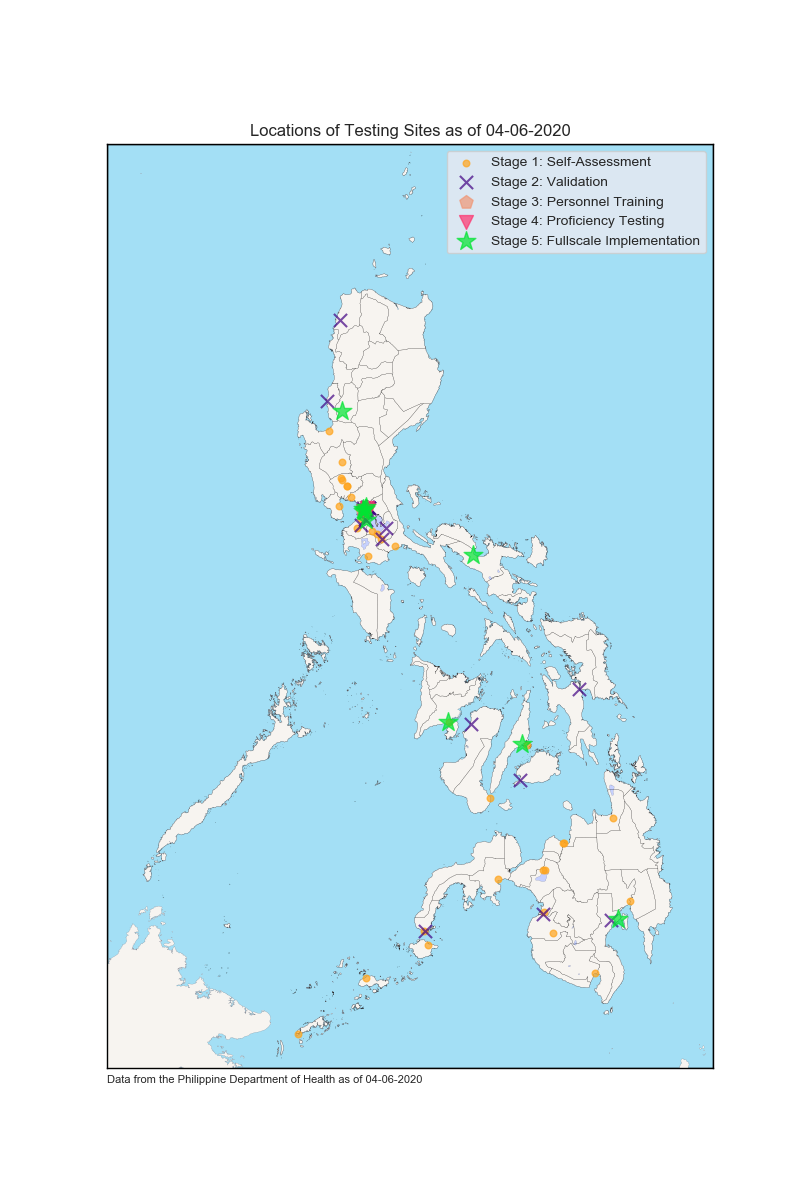

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [129]:
import matplotlib

fig, ax = plt.subplots(figsize=(8,12))

plt.title('Locations of Testing Sites as of {}'.format(time_stamp))

# default coords: llcrnrlon=115,llcrnrlat=3.5, urcrnrlon=129, urcrnrlat=22, lat_0 = 14, lon_0 = 120
m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='f',
                projection='tmerc', lat_0 = 14, lon_0 = 120) 

# Design
m.fillcontinents(color='#F7F4F0', lake_color='#c5d0fe')
m.drawmapboundary(fill_color='#a3dff5')
m.drawcoastlines(color='#555566', linewidth=0.1)

# Reading the shapefile
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)

# Conversion of lats longs wrt to the projection
def testing_scatter(n, marker, label, size, color):
    lats = [i[0] for i in df_testing_sites[df_testing_sites.stage == n].coordinates]
    longs = [i[1] for i in df_testing_sites[df_testing_sites.stage == n].coordinates]
    xpt, ypt = m(longs, lats)
    return ax.scatter(xpt, ypt, c=color, zorder=10, marker=marker, alpha=.7, s=size, label=label)

ax.text(0, -30000, 'Data from the Philippine Department of Health as of {}'.format(time_stamp), fontsize=8)

testing_scatter(1, '.', 'Stage 1: Self-Assessment', 90, color='#ffa41b')
testing_scatter(2, 'x', 'Stage 2: Validation', 90, color='#400082')
testing_scatter(3, 'p', 'Stage 3: Personnel Training', 100, color='#f09675')
testing_scatter(4, 'v', 'Stage 4: Proficiency Testing', 100, color='#fe346e')
testing_scatter(5, '*', 'Stage 5: Fullscale Implementation', 200, color='#01e432')

plt.legend(frameon=True)#loc=(0.6,0.7), 

In [130]:
plt.savefig('images/locs_of_testing_sites_{}'.format(time_stamp), dpi=800, bbox_inches='tight')

# Age distribution of confirmed cases

### Getting the number of NaN values

In [ ]:
num_nan_ages = np.sum([pd.isna(i) for i in df.age])
num_nan_ages

In [ ]:
fig = plt.figure()

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

ax = plt.subplot(111)

bins = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
n, bins, patches = ax.hist(df.age, bins, histtype='bar', color='#936ED4',rwidth=0.8, align='left') #, color='#a500ff'
patches[np.argmax(n)].set_fc('#FCB249') #color the highest

# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 100:
        break
    ax.text(bin_, n[index] + 10, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=8) #

if num_nan_ages==0:
    ax.set_title('Number of Infected Per Age Group')
    
if num_nan_ages>0:
    ax.set_title('Number of Infected Per Age Group ({} for validation)'.format(num_nan_ages))
    
# xtick labels
plt.xticks(bins)
ax.set_xlim(-10,99.9)
ax.set_ylim(0,np.max(n)+50)
    
# Removing spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Removing yticks
ax.get_yaxis().set_visible(False)

# Removing ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

# Time stamp
ax.text(81, -90, 'As of {}'.format(time_stamp), fontsize=8)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_xticklabels()])
new_labels = []
for i in range(0,len(labels)):
    new_labels.append(labels[i] + 's')
ax.set_xticklabels(new_labels, rotation=40)

plt.savefig('images/num_infected',  dpi=500, bbox_inches='tight')

In [ ]:
np.sum(n)

### Death per age group

In [ ]:
fig = plt.figure()
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

bins = np.array([30,40,50,60,70,80,90])
n, bins, patches = ax.hist(df[df.status=='dead']['age'], bins, histtype='bar', color='#87DCC0', rwidth=0.7, align='left')

ax.set_title('Deaths Per Age Group')
ax.set_ylim(0,np.max(n)+5)

patches[np.argmax(n)].set_fc('#998AD3') #color the highest

# Removing spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Removing yticks
ax.get_yaxis().set_visible(False)

# Removing ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

# label each bar with each count
for index, bin_ in enumerate(bins):        
    if index == len(n):
        break
        
    ax.text(bin_, n[index] + 0.6, int(n[index]), 
            color='black', fontweight='bold', 
            horizontalalignment='center', verticalalignment='center')
ax.text(76, -3.5, 'As of {}'.format(time_stamp), fontsize=8)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_xticklabels()])
new_labels = []
for i in range(0,len(labels)):
    new_labels.append(labels[i] + 's')
ax.set_xticklabels(new_labels)


plt.savefig('images/death_age_gp', bbox_inches='tight')

In [ ]:
np.sum(n) #sanity check

In [ ]:
len(df[df.status=='dead'])

In [ ]:
sum(df[df.status=='dead']['age'] > 60) / len(df[df.status=='dead']['age']) * 100

of deaths are seniors (60 years old and up)

# Time Series Plot of deaths

In [ ]:
df_dates = df.lab_confirmation_date.value_counts().rename_axis('date').to_frame('count')

# Sorting the date
df_dates.sort_values(by='date', inplace=True)

# Making a new row of cumulative sum
df_dates['cumulative'] = df_dates['count'].cumsum()
df_dates.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

df_dates['cumulative'][1:].plot(ax=ax, marker='o', label='Cumulative', lw=1, color='#4da6ff', ms=4)
ax.vlines(df_dates.index[1:], ymin=0, ymax=df_dates['count'][1:], lw=1, colors='#ff4d4d', label='New')
ax.scatter(df_dates.index[1:], df_dates['count'][1:], color='#ff4d4d', marker='D', s=4)


ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


plt.title('Confirmed Positive Cases as of {}'.format(time_stamp))
plt.xlabel('Date')
plt.ylabel('Count')


plt.ylim(0, 3300)
plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-04-15'))
plt.xticks(rotation=25)


# Important events
# ax.axvline(pd.to_datetime('2020-03-17'), lw=0.5, color='#ffa64d')
# ax.text(pd.to_datetime('2020-03-17'), 1100, '   Enhanced Community\n   Quarantine takes\n   effect throughout\n   Luzon', fontsize=8)

# ax.axvline(pd.to_datetime('2020-03-23'), lw=0.5, color='#ffa64d')
# ax.text(pd.to_datetime('2020-03-23'), 1600, '   Congress grants\n   President Duterte\n   emergency powers', fontsize=8)

# ax.axvline(pd.to_datetime('2020-03-30'), lw=0.5, color='#ffa64d')
# ax.text(pd.to_datetime('2020-03-30'), 1900, '   Cebu Governor Gwen Garcia\n   places Cebu City on Enhanced\n   Community Quarantine ', fontsize=8)

# ax.axvline(pd.to_datetime('2020-04-04'), lw=0.5, color='#ffa64d')
# ax.text(pd.to_datetime('2020-04-04'), 2400, '   Mayor Sara Duterte\n   places Davao City\n   on Enhanced Community\n   Quarantine\n\n   FDA approves\n   UP-NIH test kits', fontsize=8)

# ax.axvline(pd.to_datetime('2020-04-14'), lw=0.5, color='#ffa64d')
# ax.text(pd.to_datetime('2020-04-14'), 1700, '   Mass testing begins', fontsize=7)

plt.legend(loc=2)
plt.grid(True)

#plt.savefig('images/total_cases', bbox_inches='tight')

# Exponential curve

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

df_dates['cumulative'][1:].plot(ax=ax, label='Cumulative', color='k', lw=0.5)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


plt.title('Confirmed Positive Cases')
plt.xlabel('Date')
plt.ylabel('Count')

plt.xticks(rotation=25)
plt.xlim(pd.to_datetime('2020-03-04'), pd.to_datetime('2020-04-20'))


ax.set_yscale('log')
plt.ylim((10^0, 10**5) )
plt.grid(True)
#plt.savefig('images/exponential', bbox_inches='tight')

# Time series for the mean time due to incomplete data

In [6]:
df_tally = pd.read_csv('Raw Data/tally.csv', parse_dates=['date'])
df_tally.set_index('date', inplace=True)
df_tally.head()

,total_positive,total_deaths,total_recovered
date,,,
2020-01-31,3,0,1
2020-02-01,3,1,2
2020-03-06,5,1,2
2020-03-07,6,1,2
2020-03-08,10,1,2


In [7]:
ls_positive = np.array(df_tally.total_positive)

new_cases_per_day = np.array([0] + [ls_positive[i] - ls_positive[i-1] for i in range(1, len(ls_positive))])

<IPython.core.display.Javascript object>


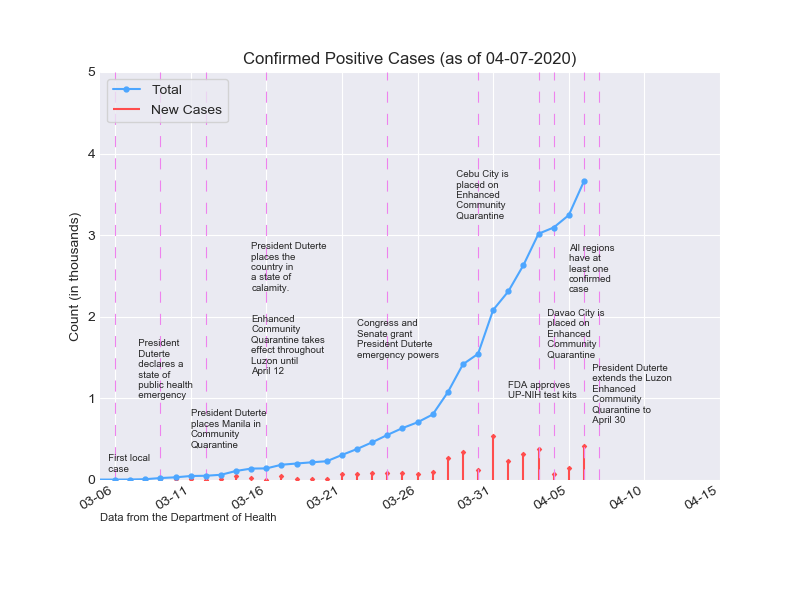

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')


# Important events
ax.axvline(pd.to_datetime('2020-03-06'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-05'), 0.1, '   First local\n   case', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-9'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-07'), 1, '   President\n   Duterte\n   declares a\n   state of\n   public health\n   emergency', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-10'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-08'), 1.7, '   Classes in all\n   levels are\n   suspended from\n   March 10-14', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-12'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-11'), 0.4, 'President Duterte\nplaces Manila in\nCommunity\nQuarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-16'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-15'), 1.3, 'President Duterte\nplaces the\ncountry in\na state of\ncalamity.\n\n\nEnhanced\nCommunity\nQuarantine takes\neffect throughout\nLuzon until\nApril 12', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-17'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-16'), 2.2, '  Airline companies\n  start cancellations\n  of domestic flights', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-24'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-22'), 1.5, 'Congress and\nSenate grant\nPresident Duterte\nemergency powers', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-28'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-26'), 2.4, 'Number of\nconfirmed\npositive cases\nsurpass the\n1000-mark', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-30'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-28'), 3.2, '   Cebu City is\n   placed on\n   Enhanced\n   Community\n   Quarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-03'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-01'), 1, 'FDA approves\nUP-NIH test kits', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-04'), lw=.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-03'), 1.5, '   Davao City is\n   placed on\n   Enhanced\n   Community\n   Quarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-06'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-05'), 2.3, 'All regions\nhave at\nleast one\nconfirmed\ncase', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-07'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-06'), 0.7, '   President Duterte\n   extends the Luzon\n   Enhanced\n   Community\n   Quarantine to\n   April 30', fontsize=7)



# Plots
df_tally['total_positive'].copy().apply(lambda x: x / 1000).plot(ax=ax, marker='o',
                                            label='Total', lw=1.5, color='#4da6ff', ms=3.5)
ax.vlines(df_tally.index, ymin=0, ymax=new_cases_per_day/1000, lw=1.5, colors='#ff4d4d', label='New Cases') # 
ax.scatter(x=df_tally.index, y=new_cases_per_day/1000, color='#ff4d4d', marker='D', s=4)



plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-04-15'))
plt.ylim(0, 5)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.title('Confirmed Positive Cases (as of {})'.format(time_stamp))
plt.xlabel(' ')
plt.ylabel('Count (in thousands)')


plt.legend(loc=2, frameon=True)
plt.grid(True)

ax.text(pd.to_datetime('2020-03-05'), -0.5, 'Data from the Department of Health', fontsize=8)

plt.savefig('images/total_cases', dpi=300, bbox_inches='tight')

# Exponential

<IPython.core.display.Javascript object>


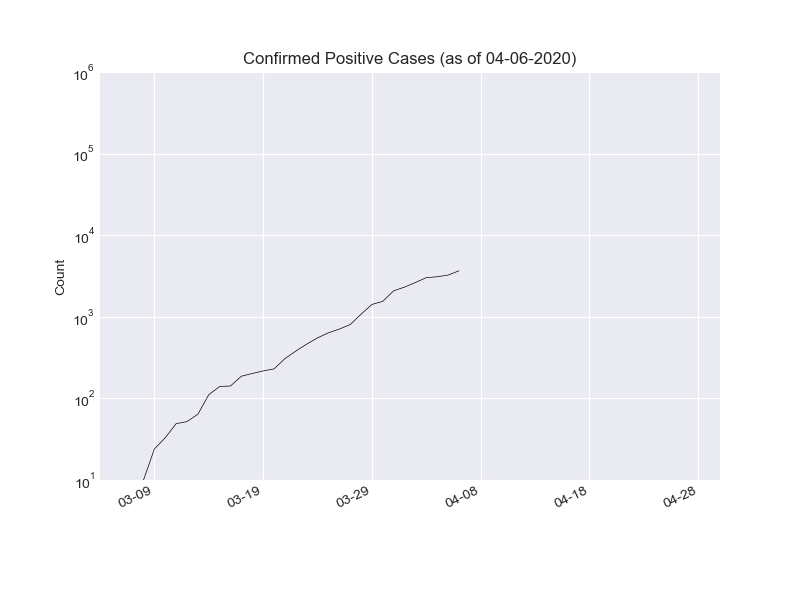

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

df_tally['total_positive'].plot(ax=ax, label='Cumulative', color='k', lw=0.5)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.title('Confirmed Positive Cases (as of {})'.format(time_stamp))
plt.xlabel('Date')
plt.ylabel('Count')

plt.xticks(rotation=25)
plt.xlim(pd.to_datetime('2020-03-04'), pd.to_datetime('2020-04-30'))

plt.xlabel(' ')
ax.set_yscale('log')
plt.ylim((10^0, 10**6) )

plt.grid(True)
plt.savefig('images/exponential', dpi=300, bbox_inches='tight')

# Recoveries vs deaths

<IPython.core.display.Javascript object>


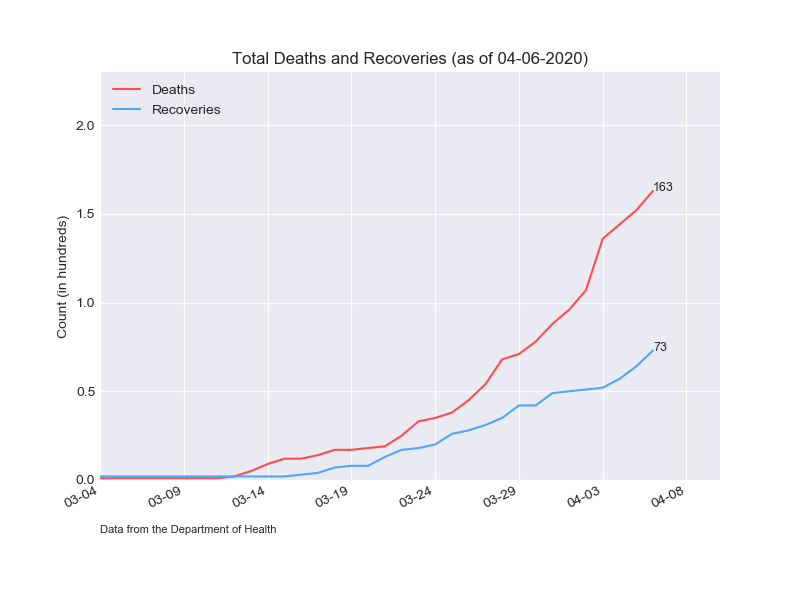

Text(2020-03-04 00:00:00, -0.3, 'Data from the Department of Health')

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

df_tally['total_deaths'].copy().apply(lambda x: x/100).plot(ax=ax, label='Deaths', 
                                                             color='#ff4d4d', lw=1.5)
df_tally['total_recovered'].copy().apply(lambda x: x/100).plot(ax=ax, label='Recoveries', 
                                                             color='#4da6ff', lw=1.5)

# Annotate
## Death
df_tally[df_tally.index == df_tally.index[-1]].total_deaths
ax.text(df_tally.index[-1], df_tally[df_tally.index == df_tally.index[-1]].total_deaths/100, 
        s=df_tally[df_tally.index == df_tally.index[-1]].total_deaths.values[0], fontsize=9)
## Recovery
df_tally[df_tally.index == df_tally.index[-1]].total_deaths
ax.text(df_tally.index[-1], df_tally[df_tally.index == df_tally.index[-1]].total_recovered/100, 
        s=df_tally[df_tally.index == df_tally.index[-1]].total_recovered.values[0], fontsize=9)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.title('Total Deaths and Recoveries (as of {})'.format(time_stamp))
plt.xlabel(' ')
plt.ylabel('Count (in hundreds)')

plt.xticks(rotation=25)
plt.xlim(pd.to_datetime('2020-03-04'), pd.to_datetime('2020-04-10'))
plt.ylim(0,2.3)

plt.legend(loc=2)
plt.grid(True)


ax.text(pd.to_datetime('2020-03-04'), -0.3, 'Data from the Department of Health', fontsize=8)